In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from read_network_v2 import get_network
import os 

lg=get_network() # get network per year in a list

def nrml(a):    # Normalize in [0,1]
    return (a - a.min()) / (a.max() - a.min())


def nrml_(a):   # Normalize in [-1,1]
    return 2*(a - a.min()) / (a.max() - a.min()) -1

In [176]:
from utilidades import get_mean_af,annotated_plot

In [177]:
plt.style.use('dark_background')

In [178]:
df=pd.read_csv('../united_names_datasets/tradeMatrix_PWG_V3.csv') # imports and exports of commodities

In [194]:
# calories data
dict_100g_kcal = {
'Maize': 356,
'Chick peas' : 358,
'Rice - total  (Rice milled equivalent)' : 360,
'Wheat': 334,
'Beans, dry': 341,
'Groundnuts, shelled' : 567,
'Soybeans': 335,
'Oats': 385,
'Barley': 332,
'Millet': 340,
'Sorghum': 343
}

caloric=df.copy(deep=True)
caloric['caloric']=caloric['Item'].map(dict_100g_kcal)
minval=caloric.caloric.min()
caloric['Value']=caloric.apply(lambda row: row['Value']*minval/row['caloric'],axis=1)
df_caloric=caloric.drop(columns=['caloric'])


# distance data
# distances_YEI=pd.read_csv('../normalization/distan_datasets/distances_YEI_v2.csv',index_col=0)
# distance=distances_YEI.merge(df,on=['exporter','importer','Year'],how='inner')
# minval=distance.distance.min()
# distance['Value']=distance.apply(lambda row: row['Value']*minval/row['distance'],axis=1)
# df_distance=distance.drop(columns=['distance'])

# population data
pop=pd.read_csv('../normalization/gdp_pop_datasets_V3/pop_concurrent.csv')
pop=df.merge(pop,how='inner',left_on=['importer','Year'],
             right_on=['country.value','date']).drop(['countryiso3code',
            'date','indicator.value','country.value'],axis=1).rename(columns={'value':'pop'})
minval=pop['pop'].min()
pop['Value']=pop.apply(lambda row: row['Value']*minval/row['pop'],axis=1)
df_pop=pop.drop(columns=['pop'])

# gdp data
gdp=pd.read_csv('../normalization/gdp_pop_datasets_V3/gdp_concurrent.csv')
gdp=df.merge(gdp,how='inner',left_on=['importer','Year'],
         right_on=['country.value','date']).drop(['countryiso3code',
        'date','indicator.value','country.value'],axis=1).rename(columns={'value':'gdp'})
minval=gdp['gdp'].min()
gdp['Value'] = gdp.apply(lambda row: row['Value']*minval/row['gdp'],axis=1)
df_gdp=gdp.drop(columns=['gdp'])

In [196]:
def antifragility(trade_data):
    
    df=trade_data
    
    # create a dictionary with global amount of trade
    # quantity = Total imports 
    # mean_val = Average price 

    items = df.groupby('Item').groups.keys()
    glob_dict = {}            
    py = df.groupby('Year')  # py = Per Year 
    for year, group in py:
        glob_dict[year] = {}
        for itm in items:
            glob_dict[year][itm] = {}
            glob_dict[year][itm]['quantity'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Quantity']['Value'].sum()
            glob_dict[year][itm]['mean_val'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Value']['Value'].mean()

    norm_dict = {}    # create a new dictionary for normalizing values
    for itm in items:
        norm_dict[itm] = {}
        for year in range(1986, 2018):
            norm_dict[itm][year] = {}
            norm_dict[itm][year]['qt'] = glob_dict[year][itm]['quantity']
            norm_dict[itm][year]['vl'] = glob_dict[year][itm]['mean_val']

    for itm in items:  # add normalized values to global yearly dictionary 
        dfa = pd.DataFrame(norm_dict[itm]).transpose()
        dfa['nqt'] = nrml(dfa['qt'])
        dfa['nvl'] = nrml(dfa['vl'])
        for year in range(1986, 2018):
            glob_dict[year][itm]['qnt'] = dfa.loc[year]['nqt']
            glob_dict[year][itm]['val'] = dfa.loc[year]['nvl']

    for year in range(1987, 2018):  #  Calculate differences of trade values on consecutive years 
        for itm in items:
            glob_dict[year][itm]['delta_pr'] = np.abs(glob_dict[year][itm]['val'] - glob_dict[year-1][itm]['val'])
            glob_dict[year][itm]['delta_qt'] = np.abs(glob_dict[year][itm]['qnt'] - glob_dict[year-1][itm]['qnt'])

    norm_dict2 = {}    # create a dictionary for normalizing delta values
    for itm in items:
        norm_dict2[itm] = {}
        for year in range(1987, 2018):
            norm_dict2[itm][year] = {}
            norm_dict2[itm][year]['delta_pr'] = glob_dict[year][itm]['delta_pr']
            norm_dict2[itm][year]['delta_qt'] = glob_dict[year][itm]['delta_qt']


    for itm in items:  # add normalized delta values to global yearly dictionary 
        dfa = pd.DataFrame(norm_dict2[itm]).transpose()
        dfa['delta_pr_n'] = nrml(dfa['delta_pr'])
        dfa['delta_qt_n'] = nrml(dfa['delta_qt'])
        for year in range(1987, 2018):
            glob_dict[year][itm]['pertb_pr'] = dfa.loc[year]['delta_pr_n']
            glob_dict[year][itm]['pertb_qt'] = dfa.loc[year]['delta_qt_n']

    for year in range(1987, 2018):  # take yearly mean of perturbation over Item list ...
        glob_dict[year]['PERTB_pr'] = pd.DataFrame(glob_dict[year]).transpose()['pertb_pr'].mean()
        glob_dict[year]['PERTB_qt'] = pd.DataFrame(glob_dict[year]).transpose()['pertb_qt'].mean()

    DF = pd.DataFrame(glob_dict).transpose()
    DF['perturb_pr'] = nrml(DF['PERTB_pr'])  # ... and Normalize them 
    DF['perturb_qt'] = nrml(DF['PERTB_qt'])
    for year in range(1987, 2018):             # Add normalized perturbations values to global dictionary 
        glob_dict[year]['pertN_pr'] = DF.loc[year]['perturb_pr']
        glob_dict[year]['pertN_qt'] = DF.loc[year]['perturb_qt']


    dict_perts = {}    #   Create dictionary and DataFrame for perturbations 
    for year in range(1987, 2018):
        dict_perts[year] = {}
        for x in ['pertN_pr','pertN_qt']:
            dict_perts[year][x] = glob_dict[year][x]
        for itm in items:
            for y in ['pertb_pr', 'pertb_qt']:
                dict_perts[year][itm+y[-3:]] = glob_dict[year][itm][y]


    dfperts = pd.DataFrame(dict_perts).transpose()    



    #  create a dictionary with amount of trade per country
    # quantity = Total imports 
    # mean_val = Average price     

    items = df.groupby('Item').groups.keys()
    dict_country = {}            
    pc = df.groupby('Year')  # pc = Per Country 

    for name, group in df.groupby('importer'):
        dict_country[name] = {}

    for name, group in df.groupby('exporter'):
        if name not in dict_country.keys():
            dict_country[name] = {}

    year = int(1986)
    for G in lg:
        for x in G.nodes():
            try:
                dict_country[x][year] = {}
                for y in G.out_edges(x):        
                    for key, val in G[y[0]][y[1]].items():
                        for k, v in val.items():
                            dict_country[x][year]['exp_'+key+'_'+k] = v
                for y in G.in_edges(x):
                    for key, val in G[y[0]][y[1]].items():
                        for k, v in val.items():
                            dict_country[x][year]['imp_'+key+'_'+k] = v
            except KeyError as e:
                continue
        year += 1


    for key, val in dict_country.items(): # compute satisfaction measures
        xxx = pd.DataFrame(val).transpose()
        for col in xxx.columns:
            xxx[col] = nrml(xxx[col])
            xxx['dlt_'+col] = xxx[col] - xxx[col].shift(1)
            xxx['dlt_'+col] = nrml_(xxx['dlt_'+col])
        for year in range(1987, 2018):
            try:
                dict_country[key][year]['dlt_in_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
                dict_country[key][year]['dlt_in_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
                dict_country[key][year]['dlt_ex_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
                dict_country[key][year]['dlt_ex_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
            except: 
                pass

    dictotal = {}  # compute antifragility 
    i = 0
    j = 0
    lp = []
    for country in dict_country.keys():
        dictotal[country] = {}
        for year in dict_perts.keys():
            dictotal[country][year] = {}
            try:
                dictotal[country][year]['af_in_pr'] = -1*dict_country[country][year]['dlt_in_pr'] * dict_perts[year]['pertN_pr']
                dictotal[country][year]['af_in_vl'] = -1*dict_country[country][year]['dlt_in_vl'] * dict_perts[year]['pertN_qt']
                dictotal[country][year]['af_ex_pr'] = dict_country[country][year]['dlt_ex_pr'] * dict_perts[year]['pertN_pr']
                dictotal[country][year]['af_ex_vl'] = dict_country[country][year]['dlt_ex_vl'] * dict_perts[year]['pertN_qt']
                dictotal[country][year]['af_in_pr2'] = -1*dict_country[country][year]['dlt_in_pr'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
                dictotal[country][year]['af_in_vl2'] = -1*dict_country[country][year]['dlt_in_vl'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
                dictotal[country][year]['af_ex_pr2'] = dict_country[country][year]['dlt_ex_pr'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
                dictotal[country][year]['af_ex_vl2'] = dict_country[country][year]['dlt_ex_vl'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
            except:
                j += 1
                lp += [country]
            i += 1
    print('total loops = ',i, 'total exceptions = ',j)

    reform = {(outerKey, innerKey): values for outerKey, innerDict in dictotal.items() for innerKey, values in innerDict.items()}
    a = pd.DataFrame(reform).transpose()
    
    return a

In [197]:
a_caloric=antifragility(df_caloric)

total loops =  7502 total exceptions =  1998


In [198]:
a_gdp = antifragility(df_gdp)

total loops =  7502 total exceptions =  1998


In [199]:
a_pop=antifragility(df_pop)

total loops =  7502 total exceptions =  1998


In [208]:
a=antifragility(df)

total loops =  7502 total exceptions =  1998


In [200]:
from utilidades import get_mean_af

In [211]:
afs={'af':a,
     'afpopulation':a_pop,
     'afgdp':a_gdp,
     'afcaloric':a_caloric}
#      'afdistance':a_distance}

directory='datasetsV2/'
if not os.path.exists(directory):
    os.mkdir(directory)

for name,antif in afs.items():
    antif.to_csv(directory+f'{name}_year_country.csv')

/home/emmanuel/miniconda3/envs/toughenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/emmanuel/miniconda3/envs/toughenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/emmanuel/miniconda3/envs/toughenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax

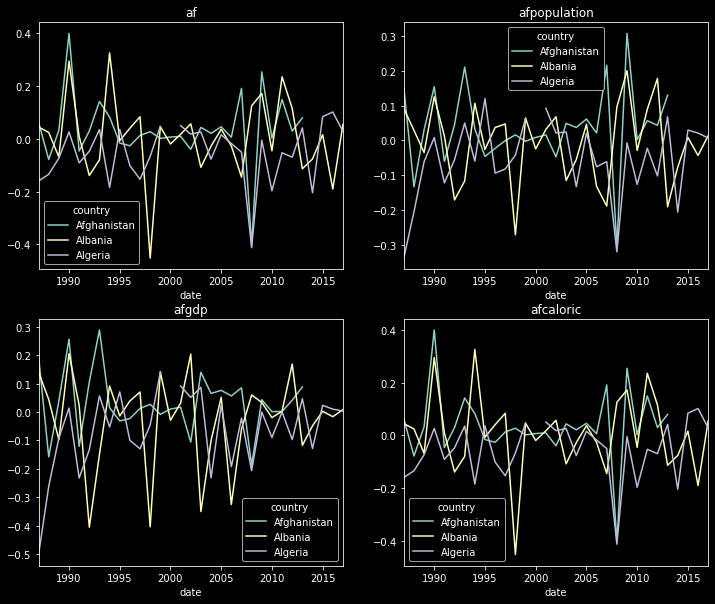

In [213]:
fig,axs=plt.subplots(2,2)
axs=axs.flatten()
for i,tupl in enumerate(afs.items()):
    name,antif=tupl
    test=antif.reset_index()
    mean_af_piv=get_mean_af(antif.reset_index())
    mean_af_piv.iloc[:3,:].T.plot(figsize=(12,10),ax=axs[i],title=name)